# Transitivity

In [1]:
import sys
import collections
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
from tf.app import use
import matplotlib.pyplot as plt

sys.path.append('/Users/cody/github/CambridgeSemiticsLab/time_collocations/tools/stats/')
from pca import apply_pca
from significance import apply_deltaP, apply_fishers

sys.path.append('/Users/cody/github/CambridgeSemiticsLab/Gesenius_data/analysis/')
from text_show import TextShower

In [2]:
from pca import plot_PCA

In [3]:
api = use('bhsa', hoist=globals())

In [4]:
ts = TextShower(
    default=['ref','verb_id', 'text' , 'clause', 'has_obj'],
    stylize=['text', 'clause']
)

In [5]:
sys.path.append('../')
from clause_relas import in_dep_calc as clause_relator

In [54]:
def clause_has_object(verb, clause_atom, clause):
    """Search a given clause for any marked objects."""
    
    clause_phrases = L.d(clause, 'phrase')
    daughters = E.mother.t(clause_atom)
    daught_relas = set(F.rela.v(d) for d in daughters)
    daught_codes = set(F.code.v(d) for d in daughters)
    phrase_functs = set(F.function.v(p) for p in clause_phrases)
    
    # we count direct speech clauses following amar as direct objects
    amar_obj = F.lex.v(verb) == '>MR[' and 999 in daught_codes 
    
    #if F.lex.v(verb) == '>MR[':
    #    raise Exception(verb, clause_atom, clause, daughters, daught_codes)
    
    # evaluate conditions for object presence
    return any([
        'Objc' in phrase_functs,
        'PreO' in phrase_functs,
        'PtcO' in phrase_functs,
        'Objc' in daught_relas,
        amar_obj,
    ])

dataset = []

for verb in F.pdp.s('verb'):
    
    # ignore low frequency clauses
    if F.freq_lex.v(verb) < 10:
        continue
    
    clause = L.u(verb, 'clause')[0]
    ca_rela = clause_relator(clause)
    
    # ignore non-main clauses to avoid 
    # the problem of, e.g., אשֶׁר subjects / objects
    # which are not marked in the database, as well as other
    # potential complications
    if ca_rela != 'Main':
        continue
    
    # process the data
    book, chapter, verse = T.sectionFromNode(verb)
    clause_atom = L.u(verb, 'clause_atom')[0]
    ref = f'{book} {chapter}:{verse}'
    vs = F.vs.v(verb)
    lex = F.lex_utf8.v(verb)
    lex_node = L.u(verb, 'lex')[0]
    verb_id = f'{lex}.{vs}'
    
    has_obj = 1 * clause_has_object(verb, clause_atom, clause)
    
    dataset.append({
        'node': verb,
        'ref': ref,
        'lex_node': lex_node,
        'lex': lex,
        'text': T.text(verb),
        'clause': T.text(clause), 
        'clause_node': clause,
        'clause_atom': clause_atom,
        'verb_id': verb_id,
        'has_obj': has_obj,
    })
    
vdf = pd.DataFrame(dataset)
vdf = vdf.set_index('node')

print(vdf.shape)

vdf.head(5)

(47840, 9)


,ref,lex_node,lex,text,clause,clause_node,clause_atom,verb_id,has_obj
node,,,,,,,,,
3,Genesis 1:1,1437569,ברא,בָּרָ֣א,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,427553,515674,ברא.qal,1
15,Genesis 1:2,1437576,היה,הָיְתָ֥ה,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ,427554,515675,היה.qal,0
33,Genesis 1:3,1437586,אמר,יֹּ֥אמֶר,וַיֹּ֥אמֶר אֱלֹהִ֖ים,427557,515678,אמר.qal,1
35,Genesis 1:3,1437576,היה,יְהִ֣י,יְהִ֣י אֹ֑ור,427558,515679,היה.qal,0
38,Genesis 1:3,1437576,היה,יְהִי־,וַֽיְהִי־אֹֽור׃,427559,515680,היה.qal,0


In [7]:
ts.show(vdf, spread=10)

showing 10 of 47840


,ref,verb_id,text,clause,has_obj
node,,,,,
3,Genesis 1:1,ברא.qal,בָּרָ֣א,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ׃,1
41447,Exodus 23:25,עבד.qal,עֲבַדְתֶּ֗ם,וַעֲבַדְתֶּ֗ם אֵ֚ת יְהוָ֣ה אֱלֹֽהֵיכֶ֔ם,1
101120,Deuteronomy 13:5,שׁמע.qal,תִשְׁמָ֔עוּ,וּבְקֹלֹ֣ו תִשְׁמָ֔עוּ,0
149218,1_Samuel 14:38,ידע.qal,דְע֣וּ,וּדְע֣וּ,0
193411,1_Kings 21:19,דבר.piel,דִבַּרְתָּ֨,וְדִבַּרְתָּ֨ אֵלָ֜יו,0
233590,Isaiah 63:8,אמר.qal,יֹּ֨אמֶר֙,וַיֹּ֨אמֶר֙,1
278935,Ezekiel 29:5,אסף.nif,תֵאָסֵ֖ף,לֹ֥א תֵאָסֵ֖ף,0
321687,Psalms 69:7,בושׁ.qal,יֵ֘בֹ֤שׁוּ,אַל־יֵ֘בֹ֤שׁוּ בִ֨י׀,0
359595,Ecclesiastes 2:2,אמר.qal,אָמַ֣רְתִּי,לִשְׂחֹ֖וק אָמַ֣רְתִּי,1


## Count verb lexeme object tendencies

In [8]:
vo_ct = pd.pivot_table(
    vdf,
    index='verb_id',
    columns='has_obj',
    aggfunc='size',
    fill_value=0,
)

vo_ct = vo_ct.loc[vo_ct.sum(1).sort_values(ascending=False).index]

vo_ct.head(10)

has_obj,0,1
verb_id,,
אמר.qal,348,3614
היה.qal,2909,34
עשׂה.qal,480,990
נתן.qal,177,1221
בוא.qal,1326,16
הלך.qal,1018,12
ראה.qal,416,410
לקח.qal,100,714
שׁמע.qal,442,256


### Cull dataset down

In [9]:
print('present data shape:')
vo_ct.shape

present data shape:


(1650, 2)

<AxesSubplot:xlabel='verb_id'>

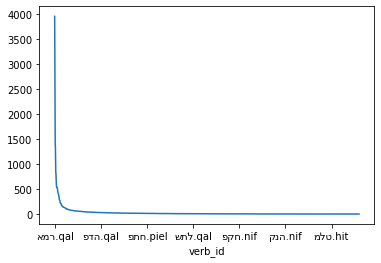

In [10]:
vo_ct.sum(1).plot()

In [11]:
vo_ct2 = vo_ct[vo_ct.sum(1) >= 30] # keep those with N observations

print('new shape of data:')
vo_ct2.shape

new shape of data:


(254, 2)

In [12]:
vo_pr = vo_ct2.div(vo_ct2.sum(1), 0)

vo_pr.head(10)

has_obj,0,1
verb_id,,
אמר.qal,0.087834,0.912166
היה.qal,0.988447,0.011553
עשׂה.qal,0.326531,0.673469
נתן.qal,0.126609,0.873391
בוא.qal,0.988077,0.011923
הלך.qal,0.988350,0.011650
ראה.qal,0.503632,0.496368
לקח.qal,0.122850,0.877150
שׁמע.qal,0.633238,0.366762


# Cluster them

In [13]:
import seaborn as sns

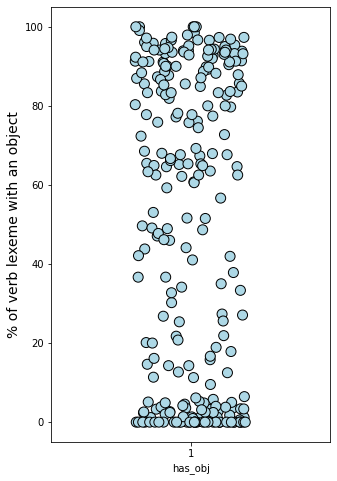

In [14]:
fig, ax = plt.subplots(figsize=(5, 8))

sns.stripplot(ax=ax, data=100*vo_pr.iloc[:, 1:2], jitter=0.2, edgecolor='black', linewidth=1, color='lightblue', size=10)
ax.set_ylabel('% of verb lexeme with an object', size=14)
plt.savefig('/Users/cody/Desktop/verb_objects.png', dpi=300, bbox_inches='tight')

## Select a subset for transitivity tagging

We will select the prototypical, unambiguous cases.

These seem to be those from 0-5% (intransitive)
and those from 60-100%. We'll leave the rest of the cases.

In [15]:
tran = vo_pr[vo_pr[1] >= 0.6]
itran = vo_pr[vo_pr[1] <= 0.05]

In [16]:
tran

has_obj,0,1
verb_id,,
אמר.qal,0.087834,0.912166
עשׂה.qal,0.326531,0.673469
נתן.qal,0.126609,0.873391
לקח.qal,0.122850,0.877150
אכל.qal,0.354049,0.645951
שׂים.qal,0.107527,0.892473
שׁלח.qal,0.346698,0.653302
נשׂא.qal,0.112981,0.887019
בוא.hif,0.089330,0.910670


In [17]:
itran

has_obj,0,1
verb_id,,
היה.qal,0.988447,0.011553
בוא.qal,0.988077,0.011923
הלך.qal,0.988350,0.011650
שׁוב.qal,0.972119,0.027881
יצא.qal,0.986817,0.013183
ישׁב.qal,0.985972,0.014028
עלה.qal,0.984581,0.015419
קום.qal,1.000000,0.000000
מות.qal,0.994521,0.005479


In [57]:
# how many verbs would this account for?
vo_ct.loc[np.array(tran.index, itran.index)].sum(1).sum()

18688

## Export for Inspection

In [44]:
from pathlib import Path
from df2gspread import df2gspread as d2g
import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = ServiceAccountCredentials.from_json_keyfile_name(
    '/Users/cody/.config/gspread/service_account.json', scope
)

drive_id = Path.home().joinpath('github/CambridgeSemiticsLab/Gesenius_data/data/_private_/keys/tran_folder.txt').read_text().strip()

In [52]:
gc = gspread.authorize(credentials)
tran_sh = gc.create("transitive_verbs", drive_id)
itran_sh = gc.create('intransitive_verbs', drive_id)
d2g.upload(tran.round(2), tran_sh.id, 'Sheet1', 
           row_names=True, col_names=True, credentials=credentials)
d2g.upload(itran.round(2), itran_sh.id, 'Sheet1', 
           row_names=True, col_names=True, credentials=credentials)

<Worksheet 'Sheet1' id:0>

# TODO: Cluster on more tendencies

A lot of dynamic verbs are in the intransitive list. It would be nice to have some separation for categories close to a stative / dynamic dichotomy. It may be possible to do this with a PCA analysis by using the `Cmpl` arguments.